No artifacts
Spectrograms
Time coherence?
3 subjects, should be split?

In [22]:
import gc
gc.collect()

0

In [18]:
dir()

['In',
 'Out',
 '_',
 '_1',
 '_11',
 '_13',
 '_14',
 '_16',
 '_9',
 '__',
 '___',
 '__builtin__',
 '__builtins__',
 '__doc__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 '_dh',
 '_i',
 '_i1',
 '_i10',
 '_i11',
 '_i12',
 '_i13',
 '_i14',
 '_i15',
 '_i16',
 '_i17',
 '_i18',
 '_i2',
 '_i3',
 '_i4',
 '_i5',
 '_i6',
 '_i7',
 '_i8',
 '_i9',
 '_ih',
 '_ii',
 '_iii',
 '_oh',
 'apply_biosppy_eeg',
 'apply_row_wise',
 'csv',
 'eeg',
 'emg',
 'exit',
 'gc',
 'get_ipython',
 'importTimeSeries',
 'multiproc',
 'multiprocessing',
 'np',
 'pd',
 'plt',
 'prnt_prog',
 'quit',
 'sig_names',
 'stats',
 'stats_on_filt_eeg',
 'tools',
 'train']

In [2]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
from biosppy.signals import eeg, emg, tools

In [3]:
import multiprocessing

def multiproc(df, func, n_jobs = None):
    if n_jobs is None:
        n_jobs = multiprocessing.cpu_count()
    num_partitions = n_jobs
    print('Parallelizing into',num_partitions,'batches.')
    df_split = np.array_split(df, num_partitions)
    pool = multiprocessing.Pool(n_jobs)
    df = pd.concat(pool.map(func, df_split))
    pool.close()
    pool.join()
    return df

def prnt_prog(i,n):
    return not i%(n//50) and print("%03d%%"%(i//(n//50)*2), end='\r',flush=True)

# func has to return a dict of features to add to the row
def apply_row_wise(df, func, prefix=''):
    n = len(df)
    rets = [prnt_prog(i,n) or func(row[1]) for i, row in enumerate(df.iterrows())]
    for field in rets[0].keys():
        df[prefix+field] = [r[field] for r in rets]
    return df

In [4]:
import csv
# returns a dict mapping sample id [int] to the raw time series [np.array]
def importTimeSeries(filename):
    datafile = open(filename, 'r')
    datareader = csv.reader(datafile)
    out = dict()
    first = True
    for row in datareader:
        if first:
            first = False
            continue
        out[int(row[0])] = np.asarray(row[1:], dtype=float)
    return out

In [5]:
train_eeg1 = importTimeSeries('train_eeg1.csv')
print('Done: train_eeg1', end='')
train_eeg2 = importTimeSeries('train_eeg2.csv')
print(', train_eeg2', end='')
train_emg  = importTimeSeries('train_emg.csv')
print(', train_emg', end='')
train = pd.read_csv('train_labels.csv').set_index('Id',drop=False)
train['eeg1'] = [train_eeg1[k] for k in train.index.values]
train['eeg2'] = [train_eeg2[k] for k in train.index.values]
train['emg']  = [train_emg [k] for k in train.index.values]
print(' ,train_labels.')
print('Merged into Dataframe: train')

Done: train_eeg1, train_eeg2, train_emg ,train_labels.
Merged into Dataframe


In [17]:
del train_eeg1
del train_eeg2
del train_emg

In [6]:
train['individual'] = [id//(len(train)/3) for id in train.Id]

In [8]:
def apply_biosppy_eeg(df): 
    def func(row):
        return eeg.eeg(signal=np.array([row.eeg1,row.eeg2]).transpose(),
                       sampling_rate=128, show=False)
    return apply_row_wise(df, func, 'eeg_')
train = multiproc(train, apply_biosppy_eeg)

Parallelizing into 72 batches.


In [21]:
sig_names =  ['eeg_theta',
              'eeg_alpha_low',
              'eeg_alpha_high',
              'eeg_beta',
              'eeg_gamma',
              'eeg_plf',
             ]
stats = {'mean':np.mean, 
         'median':np.median, 
         'min':np.min, 
         'max':np.max, 
         'std':np.std,
        }

def stats_on_filt_eeg(df):
    def func(row):
        return {(sig_name+'_'+stat_name):np.median(f(row[sig_name],axis=0))
                for sig_name in sig_names
                for (stat_name,f) in stats.items()
               }
    return apply_row_wise(df, func, '')

train = multiproc(train, stats_on_filt_eeg, n_jobs=16)

Parallelizing into 16 batches.


# Play around a bit

In [42]:
# USEFUL ANALYIS STUFF
def subsets():
    subs = [
        train[(train.y==y) & (train.individual==indiv)]
        for y in [1,2,3]
        for indiv in [0.,1.,2.]
    ]
    return subs

def randrow(i=-1):
    if i==-1:
        return train.sample(1).iloc[0]
    else:
        return subsets()[i].sample(1).iloc[0]
    
def box(field):
    plt.boxplot([sub[field] for sub in subsets()], whis=[5, 95])
    plt.show()

In [44]:
[(sub.iloc[0].individual,sub.iloc[0].y) for sub in subsets()]

[(0.0, 1),
 (1.0, 1),
 (2.0, 1),
 (-0.0, 2),
 (1.0, 2),
 (2.0, 2),
 (0.0, 3),
 (1.0, 3),
 (2.0, 3)]

Id


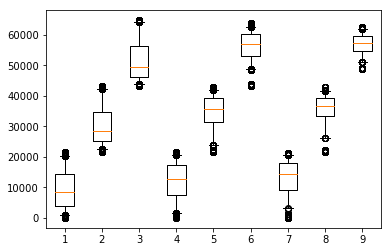

y


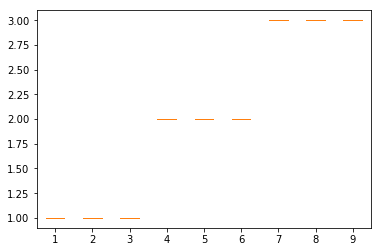

individual


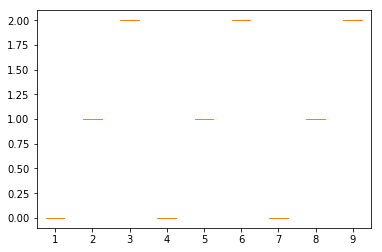

eeg_theta_mean


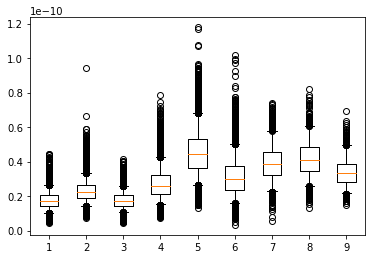

eeg_alpha_low_mean


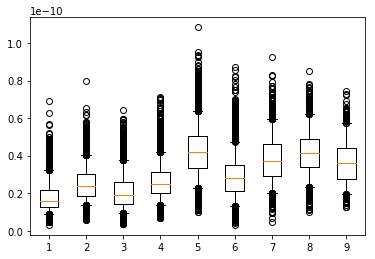

eeg_alpha_high_mean


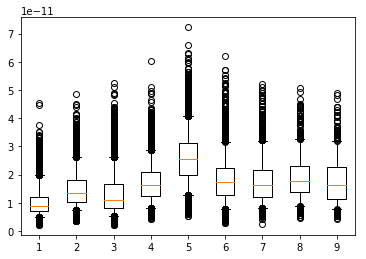

eeg_beta_mean


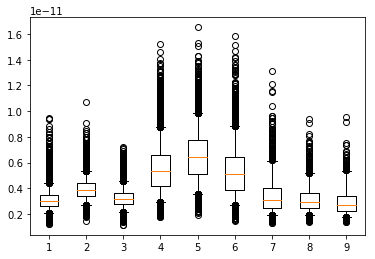

eeg_gamma_mean


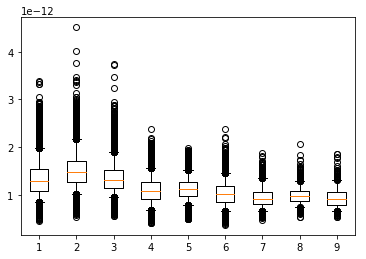

eeg_plf_mean


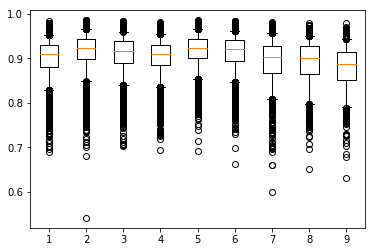

eeg_theta_median


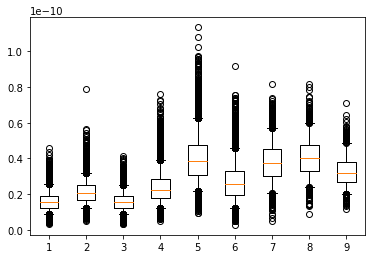

eeg_alpha_low_median


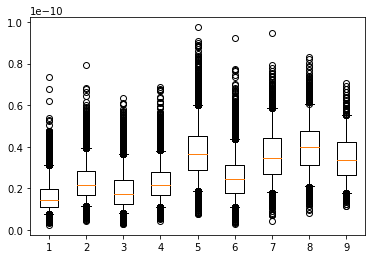

eeg_alpha_high_median


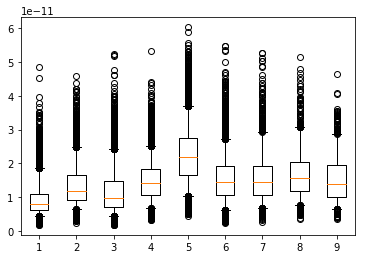

eeg_beta_median


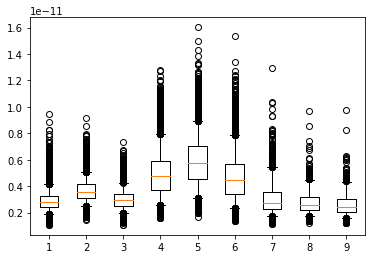

eeg_gamma_median


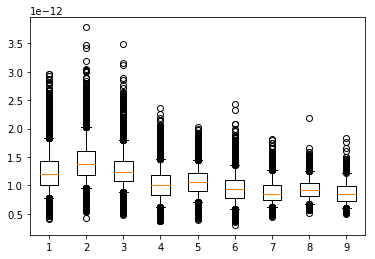

eeg_plf_median


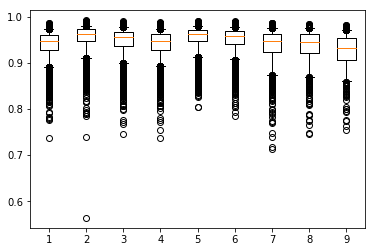

eeg_theta_min


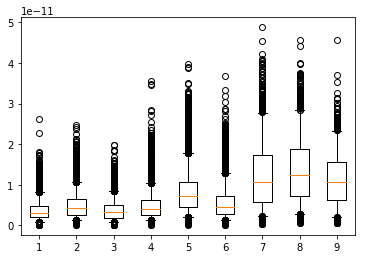

eeg_alpha_low_min


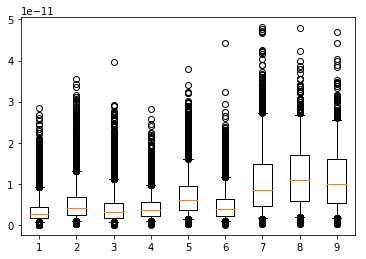

eeg_alpha_high_min


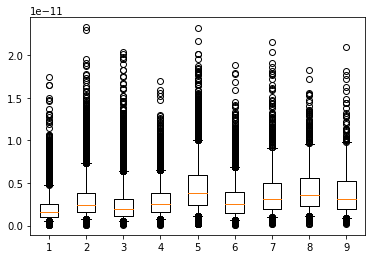

eeg_beta_min


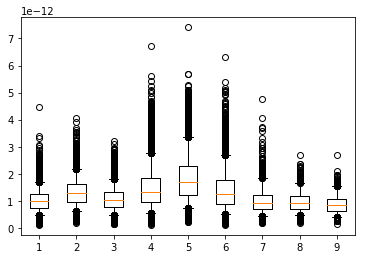

eeg_gamma_min


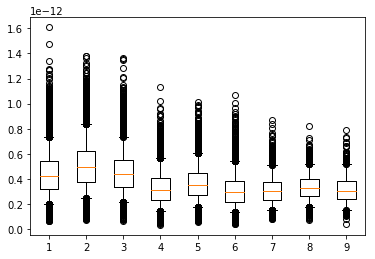

eeg_plf_min


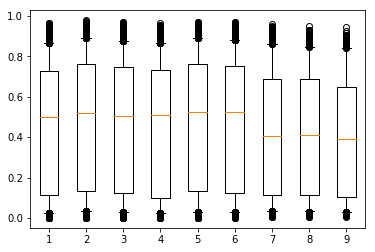

eeg_theta_max


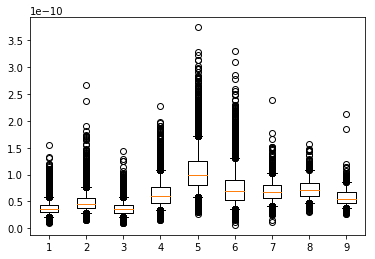

eeg_alpha_low_max


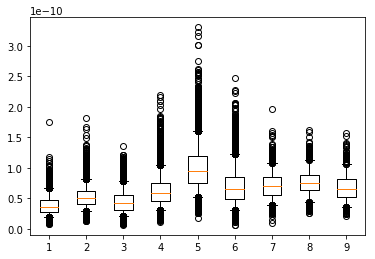

eeg_alpha_high_max


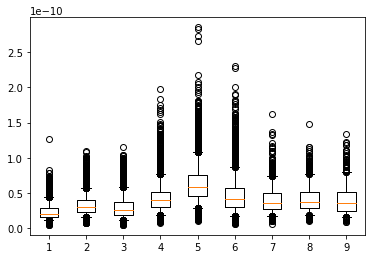

eeg_beta_max


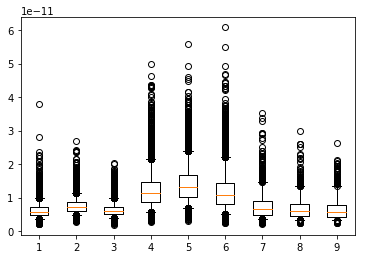

eeg_gamma_max


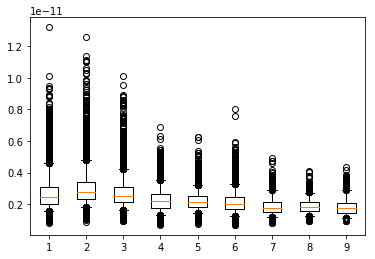

eeg_plf_max


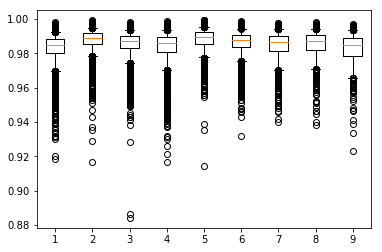

eeg_theta_std


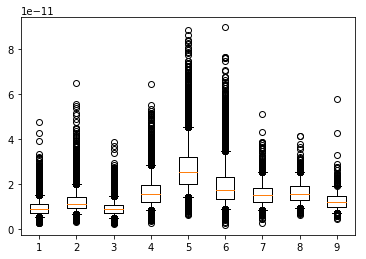

eeg_alpha_low_std


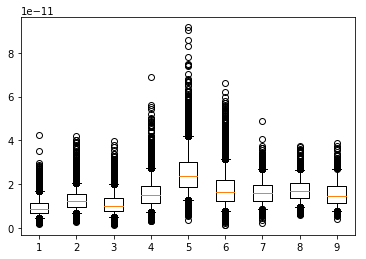

eeg_alpha_high_std


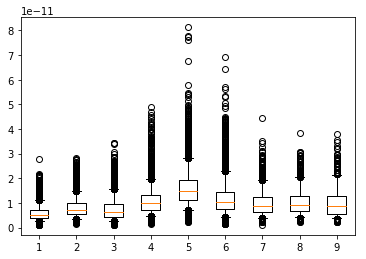

eeg_beta_std


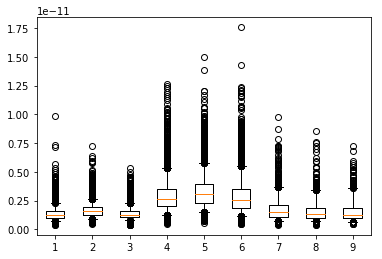

eeg_gamma_std


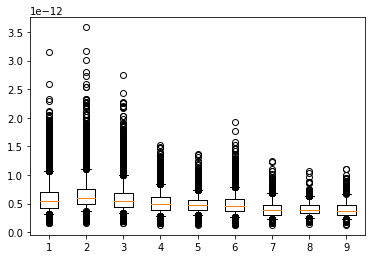

eeg_plf_std


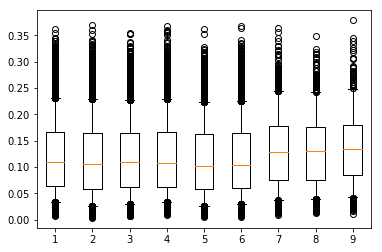

In [43]:
for feat in train.columns:
    if np.isscalar(train[feat][0]):
        print(feat)
        box(feat)

In [ ]:
for col in train.columns:
    print('{:<15s} {:<20s}'.format(col, str(np.shape(train.iloc[0][col]))))

In [ ]:
np.shape(np.mean(train.eeg_gamma,axis=1))

In [ ]:
row = randrow()
np.array([row.eeg1,row.eeg2]).transpose()

In [ ]:
row = randrow()
a

In [ ]:
row = randrow()
print(row.y)
print(row.eeg_plf_pairs)
plt.plot(row.eeg_plf)

In [ ]:
row = randrow()
print(row.y)
plt.plot(row.eeg_plf)
plt.show()
plt.plot(row.eeg_filtered)
plt.show()
plt.plot(row.eeg_alpha_low)
plt.show()
plt.plot(row.eeg_alpha_high)
plt.show()
plt.plot(row.eeg_beta)
plt.show()
plt.plot(row.eeg_gamma)
plt.show()
plt.plot(row.eeg_theta)
plt.show()

# A little domain knowledge
`biosppy.signals.eeg.car_reference(signal)`

`biosppy.signals.eeg.eeg(signal=None, sampling_rate=1000.0, labels=None, show=True)`

`[filtered]`



In [ ]:
eeg_matrix = np.array([]).transpose()[:,0,:]
biosppy_eeg = eeg.eeg(signal=eeg_matrix, sampling_rate=128, show=True)

In [ ]:
np.shape(out[0])

In [ ]:
eeg_matrix = np.array([]).transpose()[:,0,:]
#plt.plot(train.eeg1.iloc[0])

In [ ]:
eeg_matrix.shape